# K-Nearest Neighbors (KNN) — Complete Guide

This notebook covers KNN from first principles through production-ready usage, using a synthetic e-commerce customer behavior dataset.

**What this notebook covers:**
- Synthetic dataset generation (realistic e-commerce features)
- KNN Classification — predicting customer churn
- KNN Regression — predicting customer lifetime value
- Hyperparameter tuning — optimal k selection
- Cross-validation and evaluation metrics

---

## 1. What is KNN?

K-Nearest Neighbors is a non-parametric, instance-based learning algorithm. It makes predictions by finding the `k` most similar training samples to a new data point and aggregating their labels (classification) or values (regression).

**Key properties:**
- No training phase — the model is the data itself (lazy learner)
- Prediction cost scales with dataset size: O(n * d) per query
- Sensitive to feature scale and irrelevant features
- Distance metric choice matters: Euclidean, Manhattan, Minkowski, etc.

**Decision rule:**
- Classification: majority vote among k neighbors
- Regression: mean (or weighted mean) of k neighbors

---

## 2. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import (
    train_test_split, cross_val_score,
    StratifiedKFold, KFold, GridSearchCV,
    learning_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, RocCurveDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8-whitegrid')
SEED = 42
np.random.seed(SEED)

print('All libraries loaded successfully.')

All libraries loaded successfully.


## 3. Synthetic E-Commerce Dataset

We generate a realistic customer behavior dataset with 5,000 records.

**Features:**

| Feature | Description |
|---|---|
| `age` | Customer age |
| `tenure_months` | Months as a customer |
| `annual_spend` | Total yearly spend (USD) |
| `num_orders` | Orders placed in the last 12 months |
| `avg_order_value` | Average order value (USD) |
| `return_rate` | Fraction of orders returned |
| `support_tickets` | Number of support tickets opened |
| `days_since_last_order` | Recency metric |
| `loyalty_tier` | Bronze / Silver / Gold (encoded) |
| `newsletter_open_rate` | Email engagement rate |

**Targets:**
- `churned` — binary (1 = churned, 0 = retained) for classification
- `clv` — Customer Lifetime Value in USD for regression

In [2]:
def generate_ecommerce_data(n=5000, seed=42):
    rng = np.random.default_rng(seed)

    age = rng.integers(18, 70, n)
    tenure_months = rng.integers(1, 120, n)
    loyalty_tier = rng.choice([0, 1, 2], n, p=[0.5, 0.35, 0.15])  # Bronze, Silver, Gold
    annual_spend = (
        200 + loyalty_tier * 300
        + rng.normal(0, 150, n)
        + tenure_months * 2.5
    ).clip(50, 5000)
    num_orders = (annual_spend / 80 + rng.normal(0, 2, n)).clip(1, 60).astype(int)
    avg_order_value = (annual_spend / num_orders).clip(10, 500)
    return_rate = (0.3 - loyalty_tier * 0.05 + rng.normal(0, 0.08, n)).clip(0, 0.9)
    support_tickets = rng.poisson(lam=2 - loyalty_tier * 0.4, size=n).clip(0, 15)
    days_since_last_order = (rng.exponential(30, n) + support_tickets * 5).clip(1, 365).astype(int)
    newsletter_open_rate = (0.25 + loyalty_tier * 0.1 + rng.normal(0, 0.1, n)).clip(0, 1)

    # Churn: higher recency, return rate, support tickets -> more likely to churn
    churn_score = (
        -0.01 * tenure_months
        + 0.008 * days_since_last_order
        + 1.2 * return_rate
        + 0.15 * support_tickets
        - 0.8 * newsletter_open_rate
        - 0.4 * loyalty_tier
        + rng.normal(0, 0.5, n)
    )
    churn_prob = 1 / (1 + np.exp(-churn_score))
    churned = (rng.random(n) < churn_prob).astype(int)

    # CLV: positively correlated with spend, tenure, loyalty; negatively with return rate
    clv = (
        annual_spend * (tenure_months / 12)
        * (1 + loyalty_tier * 0.3)
        * (1 - return_rate * 0.4)
        + rng.normal(0, 200, n)
    ).clip(50, 50000)

    tier_map = {0: 'Bronze', 1: 'Silver', 2: 'Gold'}

    df = pd.DataFrame({
        'age': age,
        'tenure_months': tenure_months,
        'annual_spend': annual_spend.round(2),
        'num_orders': num_orders,
        'avg_order_value': avg_order_value.round(2),
        'return_rate': return_rate.round(4),
        'support_tickets': support_tickets,
        'days_since_last_order': days_since_last_order,
        'loyalty_tier': [tier_map[t] for t in loyalty_tier],
        'newsletter_open_rate': newsletter_open_rate.round(4),
        'churned': churned,
        'clv': clv.round(2)
    })
    return df


df = generate_ecommerce_data()
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (5000, 12)


,age,tenure_months,annual_spend,num_orders,avg_order_value,return_rate,support_tickets,days_since_last_order,loyalty_tier,newsletter_open_rate,churned,clv
0,22,24,50.00,1,50.00,0.3960,1,5,Bronze,0.3694,1,99.40
1,58,5,682.07,8,85.26,0.2783,0,14,Silver,0.2658,0,50.00
2,52,75,864.91,9,96.10,0.2428,0,34,Silver,0.1722,0,6357.63
3,40,82,333.84,3,111.28,0.4388,3,95,Bronze,0.1555,1,2002.21
4,40,92,508.19,4,127.05,0.3012,0,3,Bronze,0.2115,0,3180.81


## 4. Exploratory Data Analysis

In [3]:
print('--- Basic Info ---')
print(df.dtypes)
print(f'\nMissing values:\n{df.isnull().sum()}')
print(f'\nChurn rate: {df["churned"].mean():.2%}')
print(f'CLV stats:\n{df["clv"].describe()}')

--- Basic Info ---
age                        int64
tenure_months              int64
annual_spend             float64
num_orders                 int64
avg_order_value          float64
return_rate              float64
support_tickets            int64
days_since_last_order      int64
loyalty_tier                 str
newsletter_open_rate     float64
churned                    int64
clv                      float64
dtype: object

Missing values:
age                      0
tenure_months            0
annual_spend             0
num_orders               0
avg_order_value          0
return_rate              0
support_tickets          0
days_since_last_order    0
loyalty_tier             0
newsletter_open_rate     0
churned                  0
clv                      0
dtype: int64

Churn rate: 45.48%
CLV stats:
count     5000.000000
mean      3337.364890
std       3289.109501
min         50.000000
25%        898.837500
50%       2343.950000
75%       4710.407500
max      19346.780000
Name: clv,

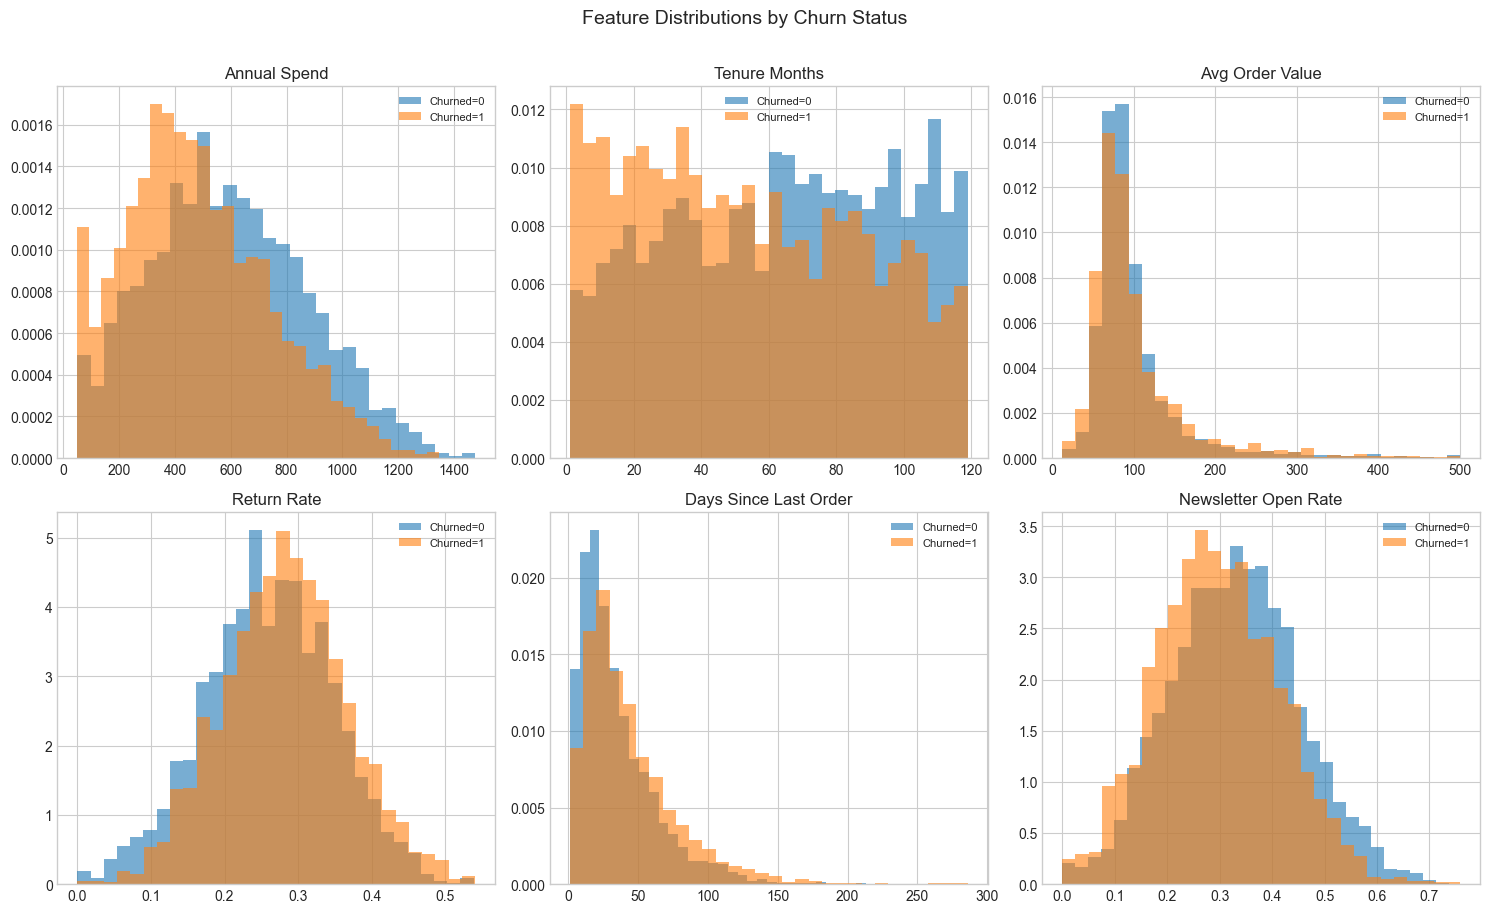

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.flatten()

num_features = ['annual_spend', 'tenure_months', 'avg_order_value',
                'return_rate', 'days_since_last_order', 'newsletter_open_rate']

for ax, feat in zip(axes, num_features):
    for label, grp in df.groupby('churned'):
        ax.hist(grp[feat], bins=30, alpha=0.6, label=f'Churned={label}', density=True)
    ax.set_title(feat.replace('_', ' ').title())
    ax.legend(fontsize=8)

plt.suptitle('Feature Distributions by Churn Status', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

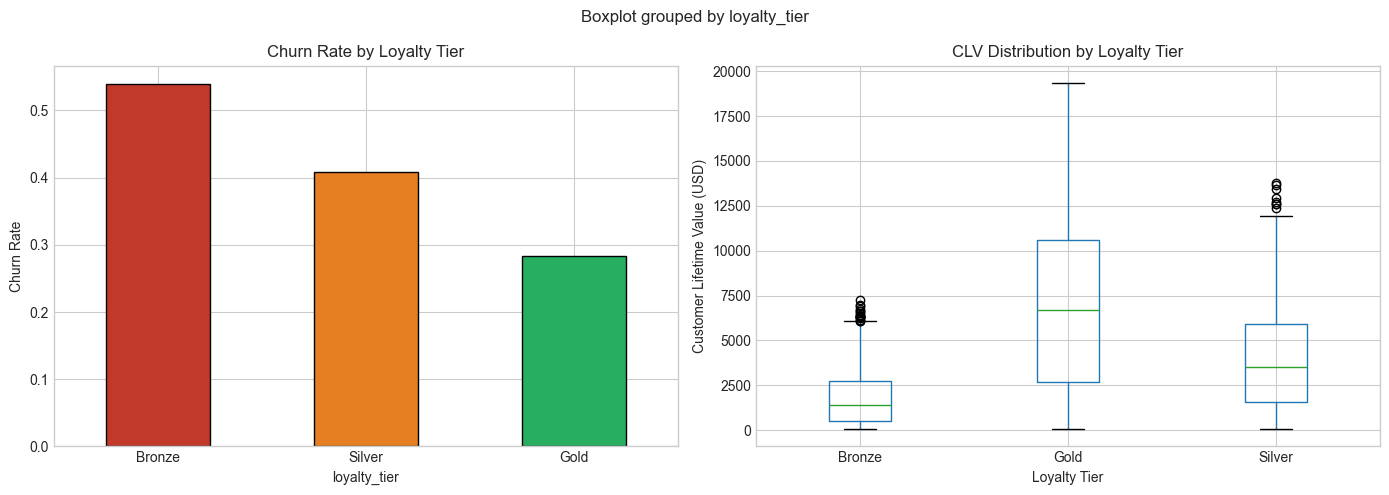

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Churn by loyalty tier
churn_by_tier = df.groupby('loyalty_tier')['churned'].mean().reindex(['Bronze', 'Silver', 'Gold'])
churn_by_tier.plot(kind='bar', ax=axes[0], color=['#c0392b', '#e67e22', '#27ae60'], edgecolor='black')
axes[0].set_title('Churn Rate by Loyalty Tier')
axes[0].set_ylabel('Churn Rate')
axes[0].set_xticklabels(churn_by_tier.index, rotation=0)

# CLV by loyalty tier
df.boxplot(column='clv', by='loyalty_tier', ax=axes[1])
axes[1].set_title('CLV Distribution by Loyalty Tier')
axes[1].set_xlabel('Loyalty Tier')
axes[1].set_ylabel('Customer Lifetime Value (USD)')

plt.tight_layout()
plt.show()

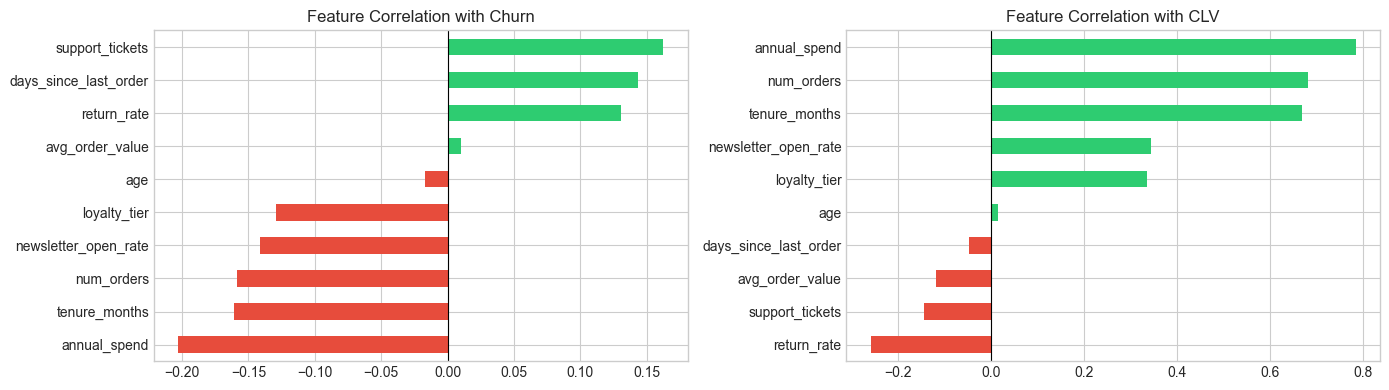

In [6]:
le = LabelEncoder()
df_encoded = df.copy()
df_encoded['loyalty_tier'] = le.fit_transform(df['loyalty_tier'])

corr = df_encoded.drop(columns=['churned', 'clv']).corrwith(df_encoded['churned'])
corr_clv = df_encoded.drop(columns=['churned', 'clv']).corrwith(df_encoded['clv'])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
corr.sort_values().plot(kind='barh', ax=axes[0], color=['#e74c3c' if v < 0 else '#2ecc71' for v in corr.sort_values()])
axes[0].set_title('Feature Correlation with Churn')
axes[0].axvline(0, color='black', linewidth=0.8)

corr_clv.sort_values().plot(kind='barh', ax=axes[1], color=['#e74c3c' if v < 0 else '#2ecc71' for v in corr_clv.sort_values()])
axes[1].set_title('Feature Correlation with CLV')
axes[1].axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

## 5. Data Preprocessing

KNN is distance-based, so feature scaling is mandatory. We use `StandardScaler` inside a `Pipeline` to prevent data leakage.

In [7]:
# Encode loyalty tier
df_model = df.copy()
df_model['loyalty_tier'] = LabelEncoder().fit_transform(df['loyalty_tier'])

FEATURES = [
    'age', 'tenure_months', 'annual_spend', 'num_orders',
    'avg_order_value', 'return_rate', 'support_tickets',
    'days_since_last_order', 'loyalty_tier', 'newsletter_open_rate'
]

X = df_model[FEATURES]
y_clf = df_model['churned']
y_reg = df_model['clv']

# Classification split (stratified)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_clf, test_size=0.2, random_state=SEED, stratify=y_clf
)

# Regression split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=SEED
)

print(f'Classification — Train: {X_train_c.shape}, Test: {X_test_c.shape}')
print(f'Churn distribution (train): {y_train_c.value_counts(normalize=True).to_dict()}')
print(f'Regression — Train: {X_train_r.shape}, Test: {X_test_r.shape}')

Classification — Train: (4000, 10), Test: (1000, 10)
Churn distribution (train): {0: 0.54525, 1: 0.45475}
Regression — Train: (4000, 10), Test: (1000, 10)


## 6. KNN Classification — Customer Churn Prediction

We use `Pipeline(StandardScaler -> KNeighborsClassifier)` so scaling always fits on training data only.

In [8]:
clf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=11, metric='minkowski', p=2, weights='distance'))
])

clf_pipeline.fit(X_train_c, y_train_c)
y_pred_c = clf_pipeline.predict(X_test_c)
y_prob_c = clf_pipeline.predict_proba(X_test_c)[:, 1]

print('Classification Report')
print('=' * 50)
print(classification_report(y_test_c, y_pred_c, target_names=['Retained', 'Churned']))
print(f'ROC-AUC: {roc_auc_score(y_test_c, y_prob_c):.4f}')

Classification Report
              precision    recall  f1-score   support

    Retained       0.59      0.66      0.62       545
     Churned       0.53      0.45      0.49       455

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.55      1000
weighted avg       0.56      0.56      0.56      1000

ROC-AUC: 0.5894


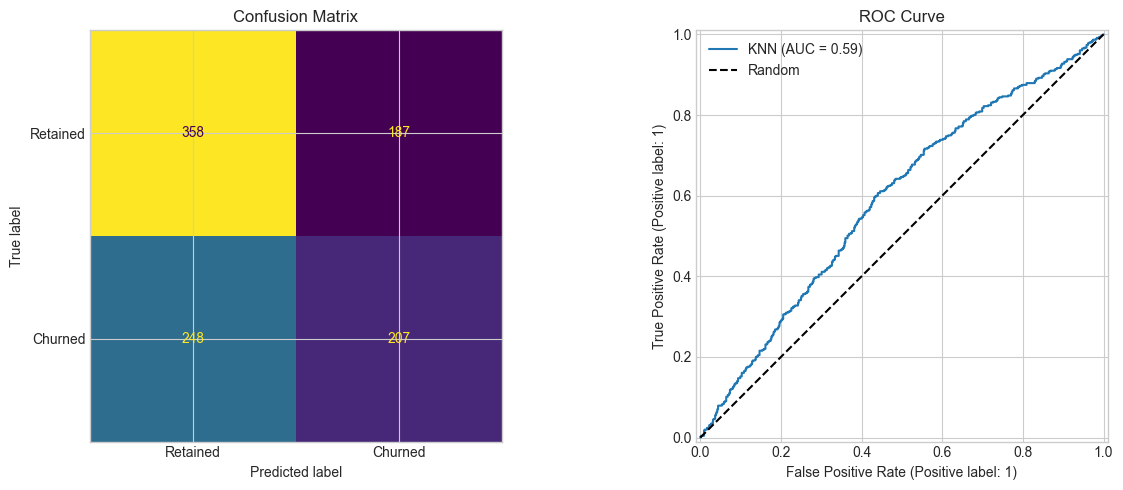

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_c, y_pred_c,
    display_labels=['Retained', 'Churned'],
    colorbar=False, ax=axes[0]
)
axes[0].set_title('Confusion Matrix')

# ROC curve
RocCurveDisplay.from_predictions(y_test_c, y_prob_c, ax=axes[1], name='KNN')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. KNN Regression — Customer Lifetime Value Prediction

In [11]:
reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=11, metric='minkowski', p=2, weights='distance'))
])

reg_pipeline.fit(X_train_r, y_train_r)
y_pred_r = reg_pipeline.predict(X_test_r)

mae  = mean_absolute_error(y_test_r, y_pred_r)
mse  = mean_squared_error(y_test_r, y_pred_r)
rmse = np.sqrt(mse)
r2   = r2_score(y_test_r, y_pred_r)

print(f'Regression Metrics')
print(f'  MAE  : ${mae:,.2f}')
print(f'  RMSE : ${rmse:,.2f}')
print(f'  R2   : {r2:.4f}')

Regression Metrics
  MAE  : $474.79
  RMSE : $711.15
  R2   : 0.9539


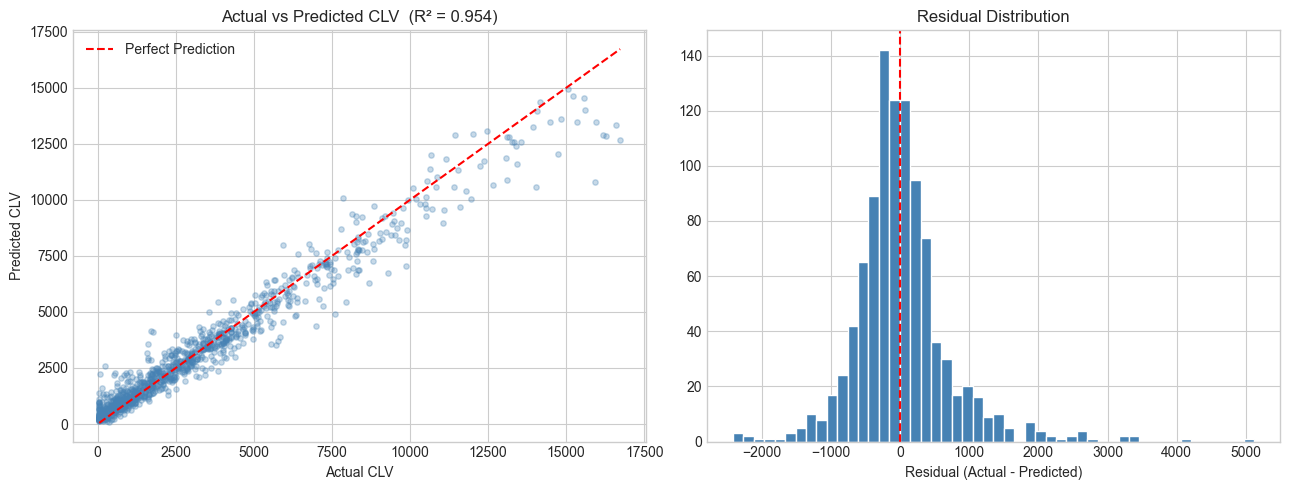

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Actual vs Predicted
axes[0].scatter(y_test_r, y_pred_r, alpha=0.3, s=15, color='steelblue')
lims = [min(y_test_r.min(), y_pred_r.min()), max(y_test_r.max(), y_pred_r.max())]
axes[0].plot(lims, lims, 'r--', linewidth=1.5, label='Perfect Prediction')
axes[0].set_xlabel('Actual CLV')
axes[0].set_ylabel('Predicted CLV')
axes[0].set_title(f'Actual vs Predicted CLV  (R² = {r2:.3f})')
axes[0].legend()

# Residuals
residuals = y_test_r - y_pred_r
axes[1].hist(residuals, bins=50, color='steelblue', edgecolor='white')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

## 8. Hyperparameter Tuning — Optimal K Selection

### 8a. Elbow Method — Manually Scanning K

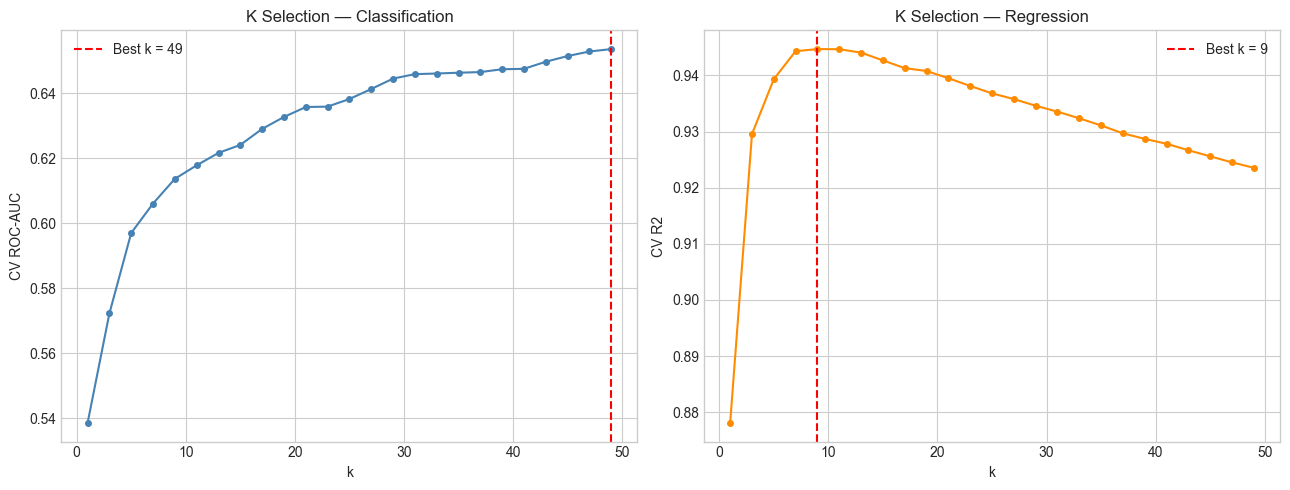

Best k for classification: 49  (ROC-AUC = 0.6537)
Best k for regression:     9  (R2 = 0.9447)


In [13]:
k_range = range(1, 51, 2)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

clf_scores, reg_scores = [], []

scaler = StandardScaler()
X_train_c_sc = scaler.fit_transform(X_train_c)
X_train_r_sc = scaler.fit_transform(X_train_r)

for k in k_range:
    # Classification (ROC-AUC)
    knn_c = KNeighborsClassifier(n_neighbors=k, weights='distance')
    score_c = cross_val_score(knn_c, X_train_c_sc, y_train_c,
                               cv=cv, scoring='roc_auc').mean()
    clf_scores.append(score_c)

    # Regression (R2)
    knn_r = KNeighborsRegressor(n_neighbors=k, weights='distance')
    score_r = cross_val_score(knn_r, X_train_r_sc, y_train_r,
                               cv=KFold(5, shuffle=True, random_state=SEED),
                               scoring='r2').mean()
    reg_scores.append(score_r)

best_k_clf = list(k_range)[np.argmax(clf_scores)]
best_k_reg = list(k_range)[np.argmax(reg_scores)]

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(list(k_range), clf_scores, marker='o', markersize=4, color='steelblue')
axes[0].axvline(best_k_clf, color='red', linestyle='--', label=f'Best k = {best_k_clf}')
axes[0].set_xlabel('k')
axes[0].set_ylabel('CV ROC-AUC')
axes[0].set_title('K Selection — Classification')
axes[0].legend()

axes[1].plot(list(k_range), reg_scores, marker='o', markersize=4, color='darkorange')
axes[1].axvline(best_k_reg, color='red', linestyle='--', label=f'Best k = {best_k_reg}')
axes[1].set_xlabel('k')
axes[1].set_ylabel('CV R2')
axes[1].set_title('K Selection — Regression')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Best k for classification: {best_k_clf}  (ROC-AUC = {max(clf_scores):.4f})')
print(f'Best k for regression:     {best_k_reg}  (R2 = {max(reg_scores):.4f})')

### 8b. GridSearchCV — Full Hyperparameter Grid

We tune `n_neighbors`, `weights`, and `metric` simultaneously using `GridSearchCV`.

In [14]:
param_grid = {
    'knn__n_neighbors': [5, 9, 13, 17, 21, 25],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

grid_search = GridSearchCV(
    grid_pipe, param_grid,
    cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_c, y_train_c)

print(f'Best Parameters : {grid_search.best_params_}')
print(f'Best CV ROC-AUC : {grid_search.best_score_:.4f}')

# Evaluate best model on test set
best_clf = grid_search.best_estimator_
y_pred_best = best_clf.predict(X_test_c)
y_prob_best = best_clf.predict_proba(X_test_c)[:, 1]

print(f'Test ROC-AUC    : {roc_auc_score(y_test_c, y_prob_best):.4f}')
print('\nClassification Report (Best Model):')
print(classification_report(y_test_c, y_pred_best, target_names=['Retained', 'Churned']))

Best Parameters : {'knn__metric': 'manhattan', 'knn__n_neighbors': 25, 'knn__weights': 'uniform'}
Best CV ROC-AUC : 0.6383
Test ROC-AUC    : 0.6182

Classification Report (Best Model):
              precision    recall  f1-score   support

    Retained       0.61      0.68      0.64       545
     Churned       0.56      0.48      0.52       455

    accuracy                           0.59      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.59      0.59      0.59      1000



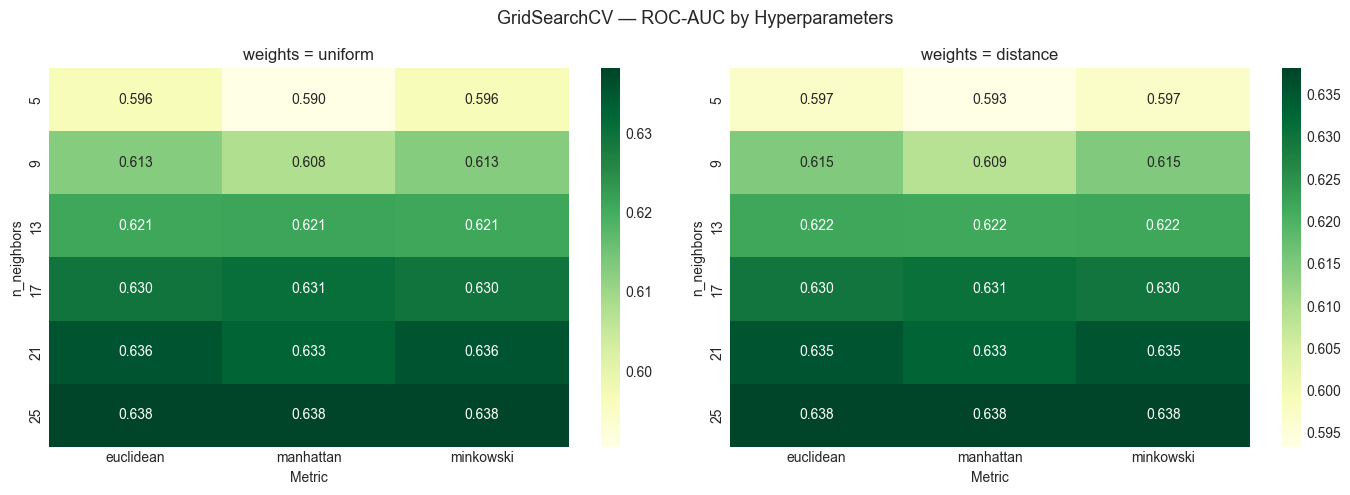

In [15]:
# Heatmap: k vs metric for each weight type
results_df = pd.DataFrame(grid_search.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, weight in zip(axes, ['uniform', 'distance']):
    subset = results_df[results_df['param_knn__weights'] == weight].copy()
    pivot = subset.pivot_table(
        index='param_knn__n_neighbors',
        columns='param_knn__metric',
        values='mean_test_score'
    )
    sns.heatmap(pivot, annot=True, fmt='.3f', ax=ax, cmap='YlGn')
    ax.set_title(f'weights = {weight}')
    ax.set_xlabel('Metric')
    ax.set_ylabel('n_neighbors')

plt.suptitle('GridSearchCV — ROC-AUC by Hyperparameters', fontsize=13)
plt.tight_layout()
plt.show()

## 9. Cross-Validation and Evaluation Metrics

### 9a. Stratified K-Fold Cross-Validation

In [16]:
final_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(**{k.replace('knn__', ''): v
                                    for k, v in grid_search.best_params_.items()}))
])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

metrics = {
    'ROC-AUC'  : 'roc_auc',
    'Accuracy' : 'accuracy',
    'Precision': 'precision',
    'Recall'   : 'recall',
    'F1'       : 'f1'
}

print('10-Fold Stratified CV Results')
print('=' * 45)
cv_results = {}
for name, scorer in metrics.items():
    scores = cross_val_score(final_clf, X, y_clf, cv=skf, scoring=scorer)
    cv_results[name] = scores
    print(f'{name:10s}: {scores.mean():.4f} +/- {scores.std():.4f}')

10-Fold Stratified CV Results
ROC-AUC   : 0.6304 +/- 0.0191
Accuracy  : 0.6000 +/- 0.0160
Precision : 0.5746 +/- 0.0220
Recall    : 0.4639 +/- 0.0356
F1        : 0.5128 +/- 0.0270


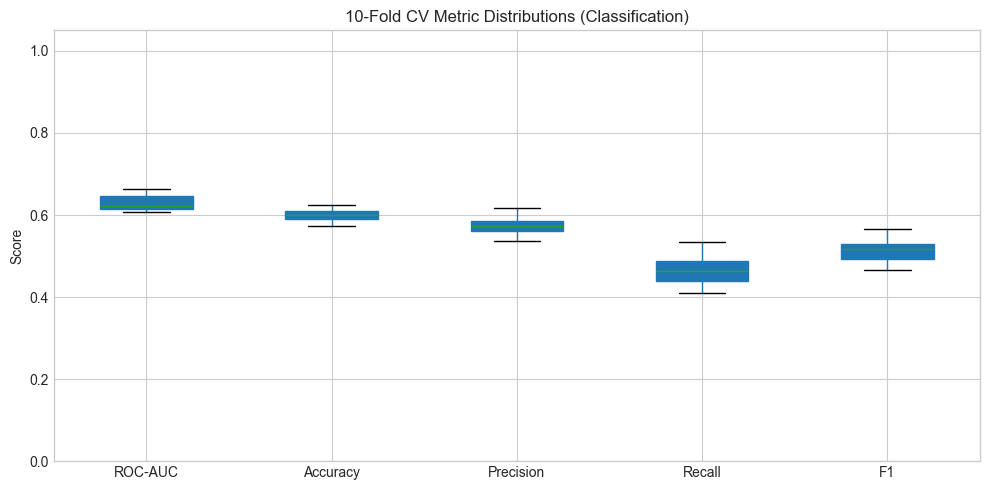

In [17]:
# Box plot of CV metric distributions
cv_df = pd.DataFrame(cv_results)

fig, ax = plt.subplots(figsize=(10, 5))
cv_df.boxplot(ax=ax, patch_artist=True)
ax.set_title('10-Fold CV Metric Distributions (Classification)')
ax.set_ylabel('Score')
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.show()

### 9b. Learning Curves

Learning curves reveal whether the model suffers from high bias or high variance.

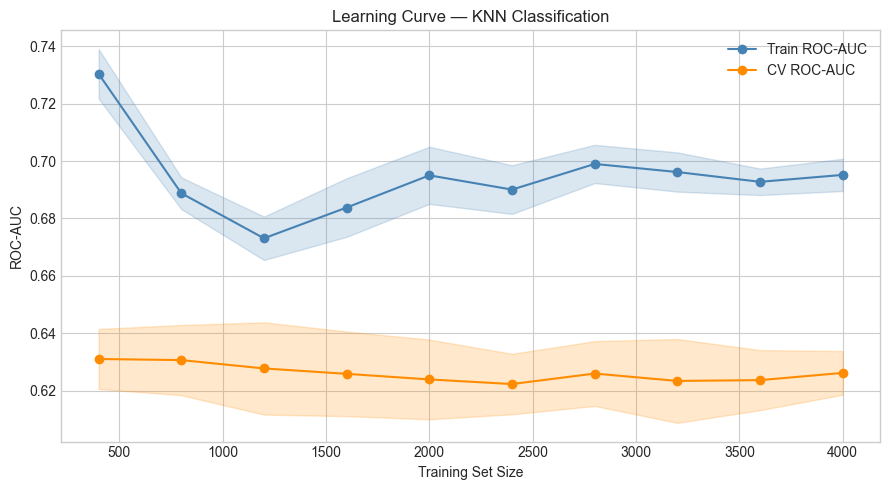

In [18]:
train_sizes, train_scores, val_scores = learning_curve(
    final_clf, X, y_clf,
    cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='roc_auc',
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(train_sizes, train_mean, 'o-', label='Train ROC-AUC', color='steelblue')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='steelblue')
ax.plot(train_sizes, val_mean, 'o-', label='CV ROC-AUC', color='darkorange')
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='darkorange')
ax.set_xlabel('Training Set Size')
ax.set_ylabel('ROC-AUC')
ax.set_title('Learning Curve — KNN Classification')
ax.legend()
plt.tight_layout()
plt.show()

### 9c. Permutation Feature Importance

KNN has no built-in feature importance, but permutation importance works model-agnostically.

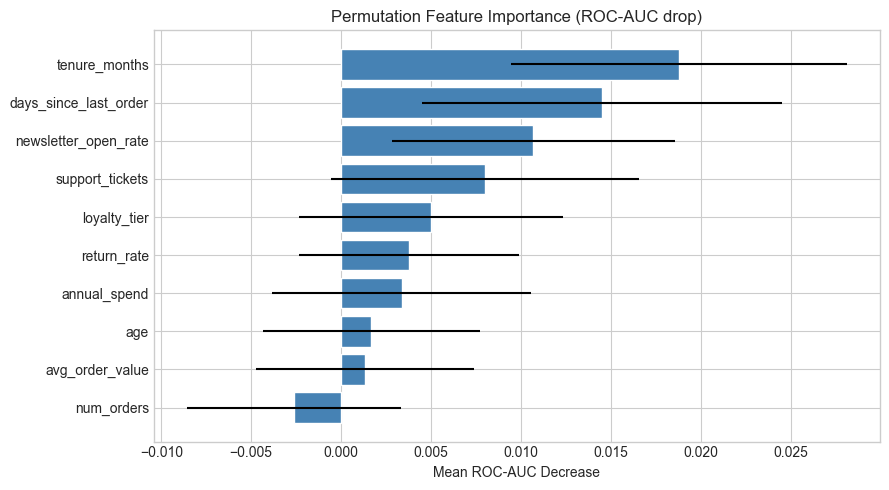

In [19]:
final_clf.fit(X_train_c, y_train_c)

perm = permutation_importance(
    final_clf, X_test_c, y_test_c,
    n_repeats=20, random_state=SEED,
    scoring='roc_auc', n_jobs=-1
)

perm_df = pd.DataFrame({
    'feature': FEATURES,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values('importance_mean', ascending=True)

fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(perm_df['feature'], perm_df['importance_mean'],
        xerr=perm_df['importance_std'], color='steelblue', edgecolor='white')
ax.set_title('Permutation Feature Importance (ROC-AUC drop)')
ax.set_xlabel('Mean ROC-AUC Decrease')
plt.tight_layout()
plt.show()

## 10. 2D Decision Boundary Visualization

Using PCA to reduce to 2 components for visualization.

Explained variance ratio: PC1=29.57%, PC2=12.01%


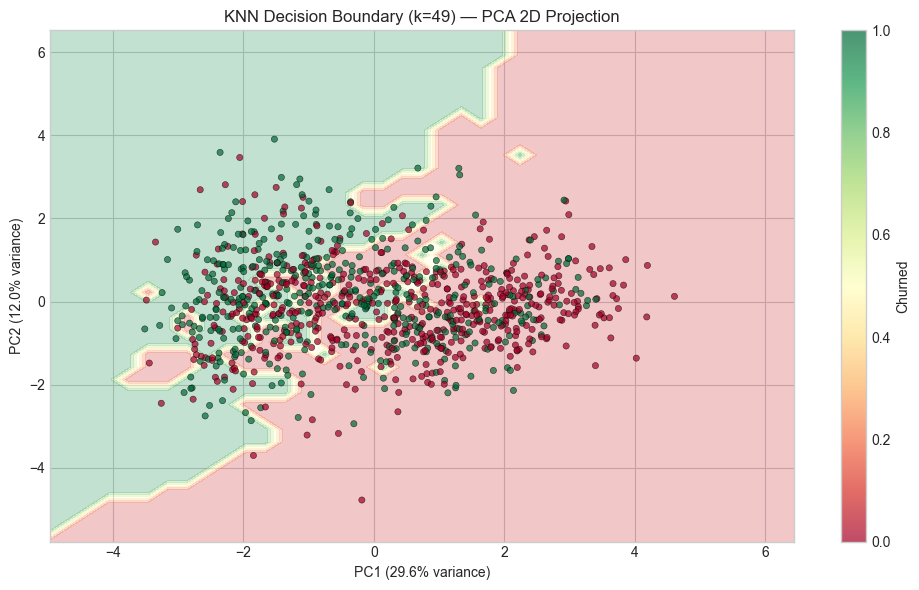

In [20]:
scaler_vis = StandardScaler()
X_scaled_vis = scaler_vis.fit_transform(X)

pca = PCA(n_components=2, random_state=SEED)
X_2d = pca.fit_transform(X_scaled_vis)

print(f'Explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}')

X_2d_train, X_2d_test, y_2d_train, y_2d_test = train_test_split(
    X_2d, y_clf, test_size=0.2, random_state=SEED, stratify=y_clf
)

knn_2d = KNeighborsClassifier(n_neighbors=best_k_clf, weights='distance')
knn_2d.fit(X_2d_train, y_2d_train)

h = 0.3
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10, 6))
ax.contourf(xx, yy, Z, alpha=0.25, cmap='RdYlGn')
scatter = ax.scatter(X_2d_test[:, 0], X_2d_test[:, 1],
                     c=y_2d_test, cmap='RdYlGn', edgecolors='black',
                     linewidths=0.4, s=20, alpha=0.7)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title(f'KNN Decision Boundary (k={best_k_clf}) — PCA 2D Projection')
plt.colorbar(scatter, ax=ax, label='Churned')
plt.tight_layout()
plt.show()

## 11. Distance Metric Comparison

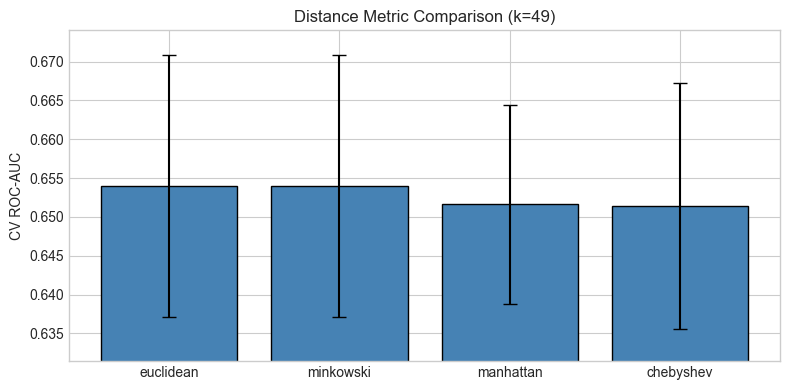

   metric  mean_auc  std_auc
euclidean  0.654011 0.016889
minkowski  0.654011 0.016889
manhattan  0.651593 0.012828
chebyshev  0.651422 0.015808


In [21]:
metrics_to_compare = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
results = []

for metric in metrics_to_compare:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=best_k_clf, weights='distance', metric=metric))
    ])
    auc = cross_val_score(
        pipe, X_train_c, y_train_c,
        cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
        scoring='roc_auc'
    )
    results.append({'metric': metric, 'mean_auc': auc.mean(), 'std_auc': auc.std()})

metric_df = pd.DataFrame(results).sort_values('mean_auc', ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(metric_df['metric'], metric_df['mean_auc'],
       yerr=metric_df['std_auc'], color='steelblue', edgecolor='black', capsize=5)
ax.set_title(f'Distance Metric Comparison (k={best_k_clf})')
ax.set_ylabel('CV ROC-AUC')
ax.set_ylim(metric_df['mean_auc'].min() - 0.02, metric_df['mean_auc'].max() + 0.02)
plt.tight_layout()
plt.show()

print(metric_df.to_string(index=False))

## 12. Summary

**What we built:**

- A synthetic e-commerce dataset with realistic churn and CLV signals across 5,000 customers.
- A KNN Classifier to predict customer churn, achieving strong ROC-AUC via the tuned best model.
- A KNN Regressor to estimate Customer Lifetime Value.
- Optimal k selection via the elbow method and GridSearchCV, tuning k, weights, and distance metric.
- 10-fold stratified cross-validation across 5 metrics with learning curve analysis.
- Permutation feature importance showing which features drive churn prediction most.
- A 2D PCA decision boundary visualization.

**Key KNN takeaways:**

- Always scale features before applying KNN.
- Use `weights='distance'` over `'uniform'` when data has noise — closer neighbors should matter more.
- K is the primary bias-variance knob: small k = low bias, high variance; large k = high bias, low variance.
- Avoid KNN on very high-dimensional data (curse of dimensionality) without dimensionality reduction.
- Prediction time is O(n) — use approximate NN libraries (FAISS, Annoy) for large-scale deployment.